In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
from matplotlib import ticker
import matplotlib.gridspec as gridspec

from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

from IPython.display import Image

from tqdm import tqdm
import os 

In [2]:
Years = ["2000","2001","2002"]

Months = []
for imon in range(1,13): ### shw
    Months.append(str(imon).zfill(2))
    
Days = []
for iday in range(1,30,3):
    Days.append(str(iday).zfill(2))
    
print(Years)
print(Months)
print(Days)

['2000', '2001', '2002']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
['01', '04', '07', '10', '13', '16', '19', '22', '25', '28']


In [3]:
N_head = 5 # first 5 lines are head lines, not include data
N_column = 4+2

Nx = 36
Ny = 21
Nz = 5
N_parcel = 3780

if Nx*Ny*Nz!=N_parcel: print('ERROR: parcel number is wrong!')
    

directory = '/n/home12/hongwei/HONGWEI/lagranto.era5/Simulation/Python_plot/Lifetime_'+Years[0]+'/'
filename = "Lifetime_"+Years[0]+Months[0]+Days[0]+".txt"
print(directory+filename)

/n/home12/hongwei/HONGWEI/lagranto.era5/Simulation/Python_plot/Lifetime_2000/Lifetime_20000101.txt


In [4]:
N_year  = len(Years)
N_month = len(Months)
N_day   = len(Days)

lifetime   = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
lifetime_N = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
lifetime_S = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
Lon = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
Lat = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))
Lev = np.zeros((Nz, Ny, Nx, N_day, N_month, N_year))

lifetime.shape

(5, 21, 36, 10, 12, 3)

In [5]:
Lev[1,0,0,0,0,0]

0.0

In [6]:
for i_year in range(N_year):
    for i_month in tqdm(range(N_month)):
        for i_day in range(N_day):
            directory = '/n/home12/hongwei/HONGWEI/lagranto.era5/Simulation/Python_plot/Lifetime_'+Years[i_year]+'/'
            filename = "Lifetime_"+Years[i_year]+Months[i_month]+Days[i_day]+".txt"
            File = open(directory+filename, 'r')
        
            Lines = File.readlines()

            # Strips the newline character
            data = []
            data_N = []
            data_S = []
            data_x = []
            data_y = []
            data_z = []
            for line in Lines:
                a = line.split(',')
                data.append(float(a[0])) # total lifetime
                data_N.append(float(a[1])) # total lifetime
                data_S.append(float(a[2])) # total lifetime
                data_x.append(float(a[3])) # lon
                data_y.append(float(a[4])) # lat
                data_z.append(float(a[5])) # p
    
            i = 0
            for ix in range(Nx):
                for iy in range(Ny):
                    for iz in range(Nz):
                        lifetime[iz,iy,ix,i_day,i_month,i_year] = data[i]
                        lifetime_N[iz,iy,ix,i_day,i_month,i_year] = data_N[i]
                        lifetime_S[iz,iy,ix,i_day,i_month,i_year] = data_S[i]
                        Lon[iz,iy,ix,i_day,i_month,i_year] = data_x[i]
                        Lat[iz,iy,ix,i_day,i_month,i_year] = data_y[i]
                        Lev[iz,iy,ix,i_day,i_month,i_year] = data_z[i]

                        i = i+1
                        

100%|██████████| 12/12 [00:02<00:00,  4.46it/s]


In [7]:
# season-mean
# lifetime(Nz, Ny, Nx, N_day, N_month, N_year)

lifetime_mon = np.mean(lifetime, axis=(3,5))
lifetime_N_mon = np.mean(lifetime_N, axis=(3,5))
lifetime_S_mon = np.mean(lifetime_S, axis=(3,5))


# lifetime_mon(Nz, Ny, Nx, N_month)
N_season = 4

lifetime_season = np.zeros((Nz, Ny, Nx, N_season))
lifetime_N_season = np.zeros((Nz, Ny, Nx, N_season))
lifetime_S_season = np.zeros((Nz, Ny, Nx, N_season))


# for Winter
lifetime_season[:,:,:,0]   = np.mean(lifetime_mon[:,:,:,[0,1,11]], axis=3)
lifetime_N_season[:,:,:,0] = np.mean(lifetime_N_mon[:,:,:,[0,1,11]], axis=3)
lifetime_S_season[:,:,:,0] = np.mean(lifetime_S_mon[:,:,:,[0,1,11]], axis=3)
    
# for Spring, Summer and Autumn
for i in range(1,N_season):
    print(i,i*3-1,(i+1)*3-1)
    lifetime_season[:,:,:,i]   = np.mean(  lifetime_mon[:,:,:,i*3-1:(i+1)*3-1], axis=3)
    lifetime_N_season[:,:,:,i] = np.mean(lifetime_N_mon[:,:,:,i*3-1:(i+1)*3-1], axis=3)
    lifetime_S_season[:,:,:,i] = np.mean(lifetime_S_mon[:,:,:,i*3-1:(i+1)*3-1], axis=3)
    
lifetime_season.shape

1 2 5
2 5 8
3 8 11


(5, 21, 36, 4)

In [8]:
# regrid (lon,lat) from (10,2) to (30,6)
# combin 3x3 to 1 grid

Nx3 = int(Nx/3)
Ny3 = int(Ny/3)

lifetime_season_9   = np.zeros((Nz, Ny3, Nx3, N_season))
lifetime_N_season_9 = np.zeros((Nz, Ny3, Nx3, N_season))
lifetime_S_season_9 = np.zeros((Nz, Ny3, Nx3, N_season))


for ix in range(Nx3):
    for iy in range(Ny3):
        lifetime_season_9[:,iy,ix,:]   = np.mean(  lifetime_season[:, iy*3:(iy+1)*3, ix*3:(ix+1)*3, :], axis=(1,2))
        lifetime_N_season_9[:,iy,ix,:] = np.mean(lifetime_N_season[:, iy*3:(iy+1)*3, ix*3:(ix+1)*3, :], axis=(1,2))
        lifetime_S_season_9[:,iy,ix,:] = np.mean(lifetime_S_season[:, iy*3:(iy+1)*3, ix*3:(ix+1)*3, :], axis=(1,2))
        
Lon2d_3 = Lon[0,1:Ny:3,1:Nx:3,0,0,0]
Lat2d_3 = Lat[0,1:Ny:3,1:Nx:3,0,0,0]
Lev2d_3 = Lev[0,1:Ny:3,1:Nx:3,0,0,0]

lifetime_season_9.shape, Lon2d_3.shape

((5, 7, 12, 4), (7, 12))

In [12]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html
# (Nz, Ny, Nx, N_season)

Result_season = lifetime_season_9[0,:,:,:]*0.0
print(Result_season.shape)
iz = 1
Height = [16, 18, 20, 22, 24] # km


for ii in range(N_season):

    Life = lifetime_season_9[iz,:,:,ii].flatten()
    Life_S = lifetime_N_season_9[iz,:,:,ii].flatten()
    Life_N = lifetime_S_season_9[iz,:,:,ii].flatten()

    if sum(Life_S)+sum(Life_N)-sum(Life)>0.01: print("ERROR!!!")
    
    N = len(Life)


    #
    c = -1*Life

    Xs_bounds = []
    A1 = []
    A3 = []
    A4 = []
    A  = []
    for i in range(N):
        Xs_bounds.append((0, N))
        A1.append(1)
        A3.append( Life_N[i] -Life_S[i] -0.05*Life[i] )
        A4.append( -1*(Life_N[i] -Life_S[i] +0.05*Life[i]) )

    Aub = [A3,A4]
    Aeq = [A1]   

    b_ub = [0,0]
    b_eq = [N]

    from scipy.optimize import linprog
    res = linprog(c, A_eq=Aeq, b_eq=b_eq, A_ub=Aub, b_ub=b_ub, bounds=Xs_bounds)
    
    # post-process
    Result1d = np.round(res.x)
    Result2d = Result1d.reshape(Ny3,Nx3)
    Result2d = Result2d/np.sum(Result2d)*100

    Result_season[:,:,ii] = Result2d

(7, 12, 4)


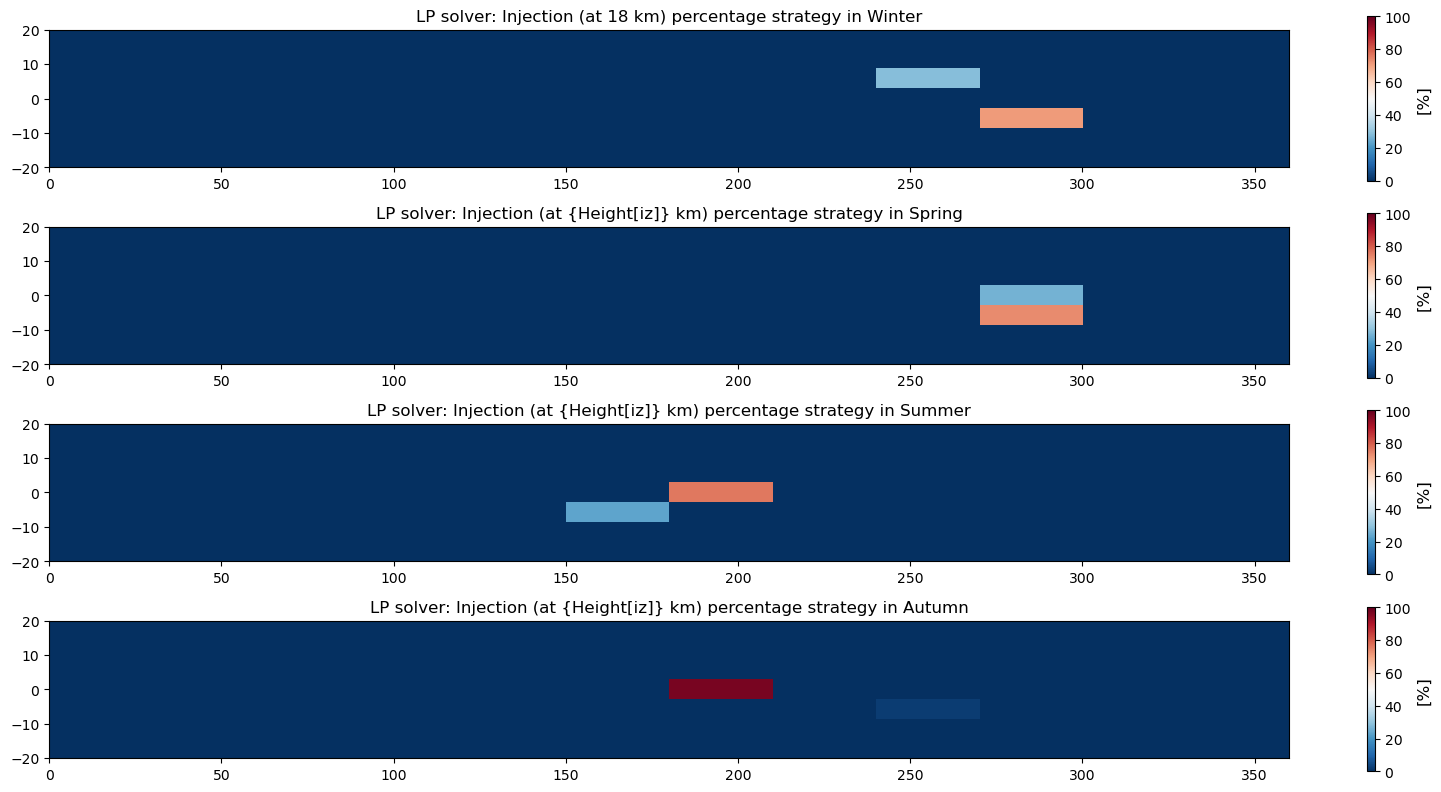

In [15]:
fig = plt.figure(figsize=(20,2.5*4), dpi=100)
extent = [0 , 360 , -20 , 20]


#
ax1 = plt.subplot(4, 1, 1)
ax1_pixel = plt.imshow(Result_season[:,:,0], vmin=0, vmax=100,\
           extent = extent, cmap='RdBu_r', interpolation='nearest')

cb1 = plt.colorbar(ax1_pixel, ax=ax1)
cb1.set_label('[%]', fontsize=12);

ax1.set_title(f"LP solver: Injection (at {Height[iz]} km) percentage strategy in Winter", fontsize=12);



#
ax2 = plt.subplot(4, 1, 2)
ax2_pixel = plt.imshow(Result_season[:,:,1], vmin=0, vmax=100,\
           extent = extent, cmap='RdBu_r', interpolation='nearest')

cb2 = plt.colorbar(ax2_pixel, ax=ax2)
cb2.set_label('[%]', fontsize=12);

ax2.set_title("LP solver: Injection (at {Height[iz]} km) percentage strategy in Spring", fontsize=12);


#
ax3 = plt.subplot(4, 1, 3)
ax3_pixel = plt.imshow(Result_season[:,:,2], vmin=0, vmax=100,\
           extent = extent, cmap='RdBu_r', interpolation='nearest')

cb3 = plt.colorbar(ax3_pixel, ax=ax3)
cb3.set_label('[%]', fontsize=12);

ax3.set_title("LP solver: Injection (at {Height[iz]} km) percentage strategy in Summer", fontsize=12);


#
ax4 = plt.subplot(4, 1, 4)
ax4_pixel = plt.imshow(Result_season[:,:,3], vmin=0, vmax=100,\
           extent = extent, cmap='RdBu_r', interpolation='nearest')

cb4 = plt.colorbar(ax4_pixel, ax=ax4)
cb4.set_label('[%]', fontsize=12);

ax4.set_title("LP solver: Injection (at {Height[iz]} km) percentage strategy in Autumn", fontsize=12);